In [1]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
 import datetime as dt

 ### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
 engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns1 = inspector.get_columns('measurement')
print('Measurement')
for c in columns1:
    print(c['name'], c["type"])
columns2 = inspector.get_columns('station')
print('\nStation')
for c in columns2:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
 # Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory climate analysis

### Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

date_list = engine.execute('SELECT date FROM measurement').fetchall()
max_date = max(date_list)
last_date = max_date[0]
final_date = dt.date.fromisoformat(last_date)
year_ago = final_date.year - 1
year_ago_date = final_date.replace(year = year_ago)
first_date = year_ago_date.isoformat()
print(last_date)
print(first_date)

2017-08-23
2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
msmt = [Measurement.date, Measurement.prcp]

past_year = session.query(*msmt).\
    filter(Measurement.date >= year_ago_date).\
    order_by(Measurement.date).all()

past_year

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(past_year, columns=['Date', 'Rain/Snow'])
prcp_df.dropna(axis=0, how='any', inplace=True)
prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values(by=['Date'])
prcp_df.head()

,Rain/Snow
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


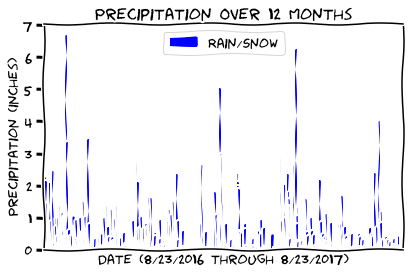

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
with plt.xkcd():
    prcp_df.plot.bar(color='b')
    plt.xticks([])
    plt.title("Precipitation Over 12 Months")
    plt.xlabel("Date (8/23/2016 through 8/23/2017)")
    plt.ylabel("Precipitation (inches)")
    plt.legend(loc=(9))
    plt.tight_layout()
    plt.show()

### Station Analysis

In [15]:
# Design a query to calculate the total number of stations.
stations = engine.execute('SELECT COUNT (DISTINCT station) FROM station').fetchall()
num_stations = stations[0][0]
num_stations

9

In [16]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order.
stat_obs = engine.execute('SELECT station, COUNT(tobs) AS tot_obs FROM measurement\
    GROUP BY station ORDER BY tot_obs DESC').fetchall()
stat_obs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Which station has the highest number of observations?
max_obs = stat_obs[0][0]
max_obs

'USC00519281'

In [18]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# last_12 = engine.execute('SELECT tobs FROM measurement WHERE station = max_obs AND date > first_date').fetchall()
obs = [Measurement.tobs]

last_12 = session.query(*obs).\
    filter(Measurement.date >= year_ago_date).\
    filter(Measurement.station == max_obs).\
    order_by(Measurement.date).all()
last_12

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

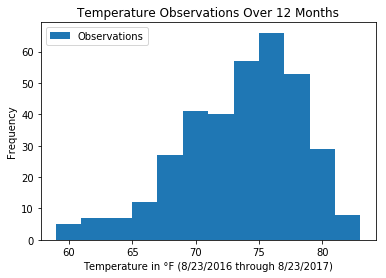

In [19]:
# Save the query results as a Pandas DataFrame
stat_df = pd.DataFrame(last_12, columns=['Observations'])
stat_df.dropna(axis=0, how='any', inplace=True)

# Plot the results as a histogram with bins=12.
legend = ['Observations']
observations = stat_df['Observations']
plt.hist(observations, bins = 12)
plt.xlabel('Temperature in °F (8/23/2016 through 8/23/2017)')
plt.ylabel('Frequency')
plt.title('Temperature Observations Over 12 Months')
plt.legend(legend, loc=2)
plt.show()

### Climate App

#### See app.py in the same folder as this notebook